# $t$-distributed stochastic neighbor embedding

If you are one of thousands who use $t$-SNE for dimensionality reduction and haven\t read the original paper, you are one lucky guy. Because here you learn that youve been wrong all along and tSNE is NOT SUITED for dimensionalty reduction. 

In [3]:
library(kernlab)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘dplyr’ was built under R version 3.5.1”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::alpha() masks kernlab::alpha()
✖ purrr::cross()   masks kernlab::cross()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


In [158]:
X <- as.matrix(iris[,1:4])

In [159]:
cov <- function(X, rbf, sigmas=1) {
    K <- -as.matrix(dist(X))^2
    K <- apply(K, 2, function(i) i / sigmas)
    K <- exp(K)
    diag(K) <- 0
    K
}

In [164]:
cov(X)[1:5, 1:5]

,1,2,3,4,5
1,0.0000000,0.7482636,0.7710516,0.6570468,0.9801987
2,0.7482636,0.0000000,0.9139312,0.8958341,0.6907343
3,0.7710516,0.9139312,0.0000000,0.9417645,0.7710516
4,0.6570468,0.8958341,0.9417645,0.0000000,0.6570468
5,0.9801987,0.6907343,0.7710516,0.6570468,0.0000000


In [160]:
gaussians <- function(X, rbf, sigmas)
{
    K <- cov(X, rbf, sigmas)
    sweep(K, 1, rowSums(K), "/")
}

In [167]:
gaussians(X, rbf, seq(5))[1:5, 1:5]

,1,2,3,4,5
1,0.00000000,0.02026183,0.02087890,0.01779182,0.02654228
2,0.02171367,0.00000000,0.02399731,0.02375854,0.02086226
3,0.02083214,0.02204672,0.00000000,0.02226829,0.02083214
4,0.01895526,0.02048271,0.02074035,0.00000000,0.01895526
5,0.01891693,0.01763803,0.01803037,0.01746253,0.00000000


In [197]:
perplexity <- function(X, sigma, idx)
{
    gau <- gaussians(X, rbf, sigma)[idx, -idx]
    lo <- log2(gau)
    idx <- is.finite(lo)
    per <- 2^(- sum(gau[idx] * lo[idx]))
    per
}

In [198]:
sigmas <- function(X, target) 
{
    sigs <- rep(1, nrow(X))
    for (ps in seq(nrow(X)))
    {
        low <- 0
        up <- 100
        for (i in seq(100))
        {
            mid <- (low + up) / 2
            val <- perplexity(X, mid, ps)
            if (val > target) up <- mid
            else low <- mid
            if (abs(val - target) < 0.01) break
        }
        sigs[ps] <- mid
    }
    
    sigs
}

In [208]:
sigs <- sigmas(X, 50)

In [209]:
students <- function(X, rbf)
{
    K <- cov(X, rbf)
    K <- 1 / (1 - log(K))
    K / apply(K, 1, sum)
}

In [210]:
p <- gaussians(X, rbf, sigs)
p <- (p + t(p)) / (2 * nrow(X)) 

In [211]:
eta <- .5

In [212]:
gradient <- function(p, q, y) 
{
    4 * do.call("rbind", lapply(seq(nrow(p)), function(i) {
        pq <- p[i, ] - q[i, ]
        yi <- y[i,] - y
        t <- 1 + apply(yi, 1, function(s) sum(s^2))
        apply(pq * yi / t, 2, sum)
    }))
}

In [213]:
y <- matrix(rnorm(nrow(X) * 2, 0, 10e-3), nrow(X))
q <- students(X, rbf)
for (t in seq(1000))
{
    q <- students(y, rbf)
    y <- y + eta * gradient(p, q, y)
}

In [214]:
options(repr.plot.height=3)

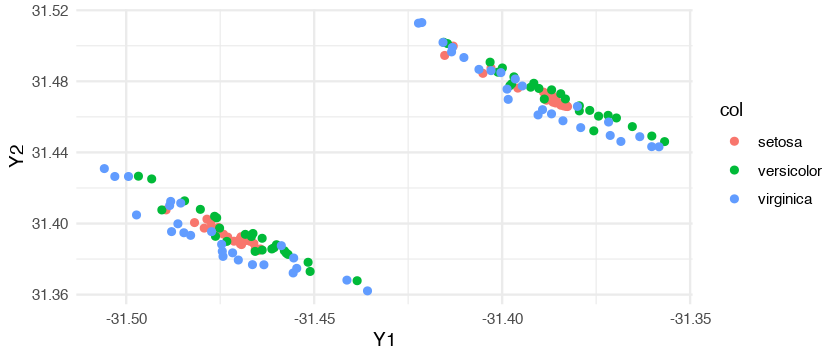

In [215]:
data.frame(Y1=y[,1], Y2=y[,2], col=iris$Species) %>%
    ggplot() +
    geom_point(aes(Y1, Y2, col=col)) +
    theme_minimal()